Loading FastText features and labels...
Loaded 15000 samples with 300-dim FastText features.
Training set: 12000 samples
Test set: 3000 samples
Categories: ['economic', 'environment', 'health', 'politic', 'sport', 'technology']

Training models on FastText features

Training and evaluating SVM (FastText)...
CV accuracies: [0.65708333 0.65458333 0.6625     0.70875    0.68916667]
Mean CV accuracy: 0.6744 (±0.0211)
Training accuracy: 0.6678
Training completed in 533.24 seconds
SVM (FastText) model saved
Test Accuracy: 0.6787
Test Precision: 0.8375
Test Recall: 0.6787
Test F1 Score: 0.6715


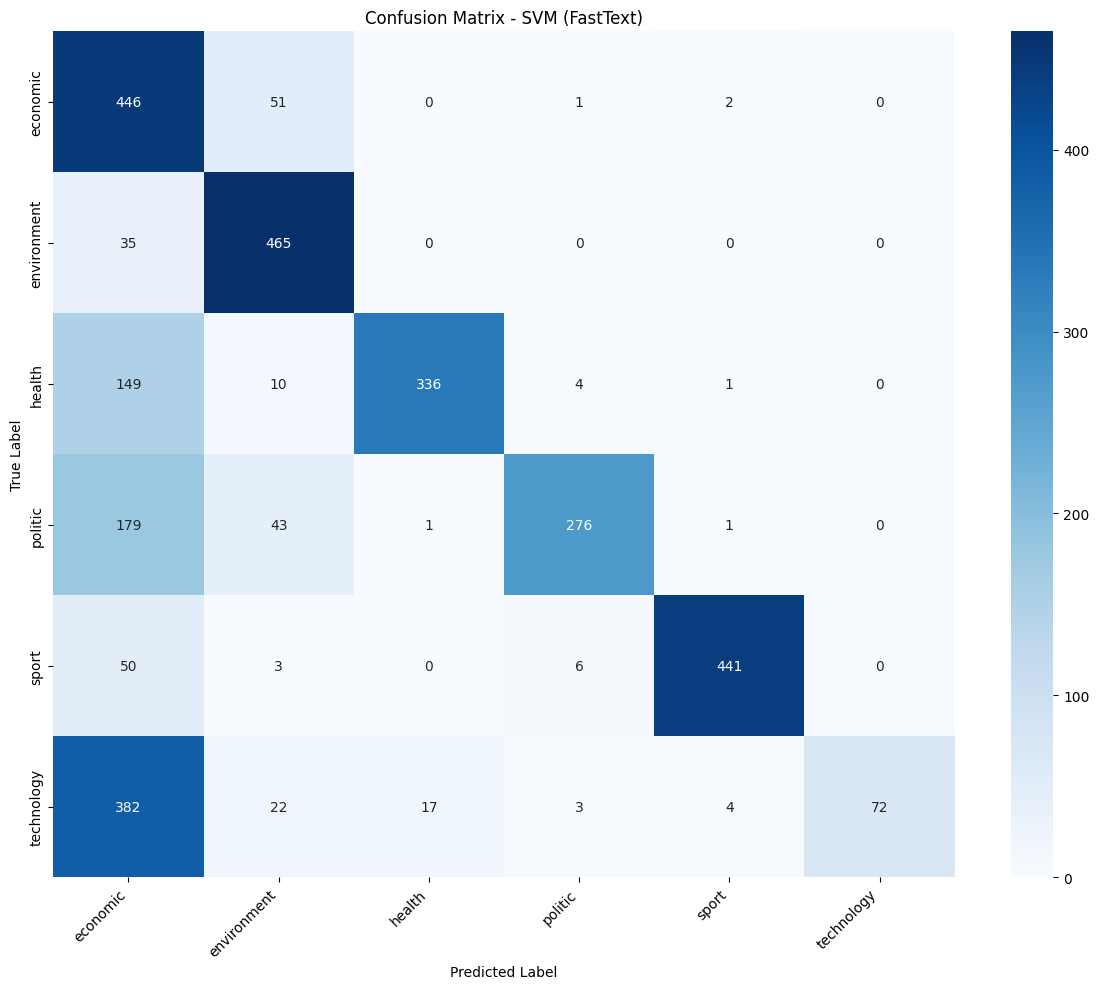


Classification Report:
              precision    recall  f1-score   support

    economic       0.36      0.89      0.51       500
 environment       0.78      0.93      0.85       500
      health       0.95      0.67      0.79       500
     politic       0.95      0.55      0.70       500
       sport       0.98      0.88      0.93       500
  technology       1.00      0.14      0.25       500

    accuracy                           0.68      3000
   macro avg       0.84      0.68      0.67      3000
weighted avg       0.84      0.68      0.67      3000


Generating ROC curves (one-vs-rest)...


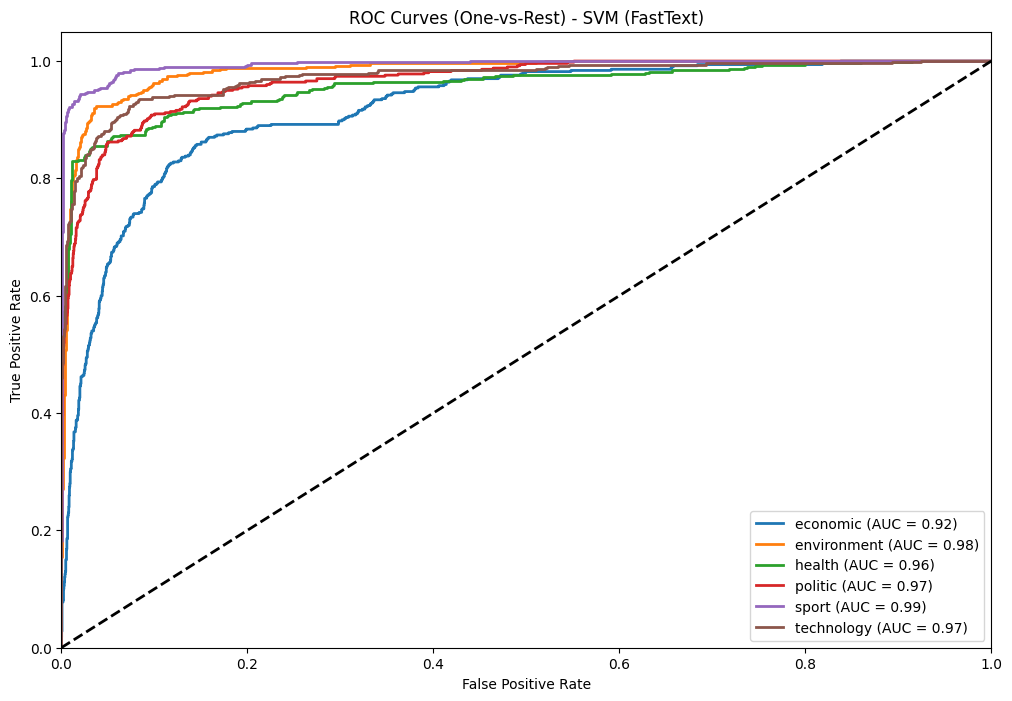


Training and evaluating MNB (FastText, shifted)...
CV accuracies: [0.83916667 0.85333333 0.84833333 0.86       0.84541667]
Mean CV accuracy: 0.8492 (±0.0071)
Training accuracy: 0.8500
Training completed in 0.15 seconds
MNB (FastText, shifted) model saved
Test Accuracy: 0.8527
Test Precision: 0.8641
Test Recall: 0.8527
Test F1 Score: 0.8554


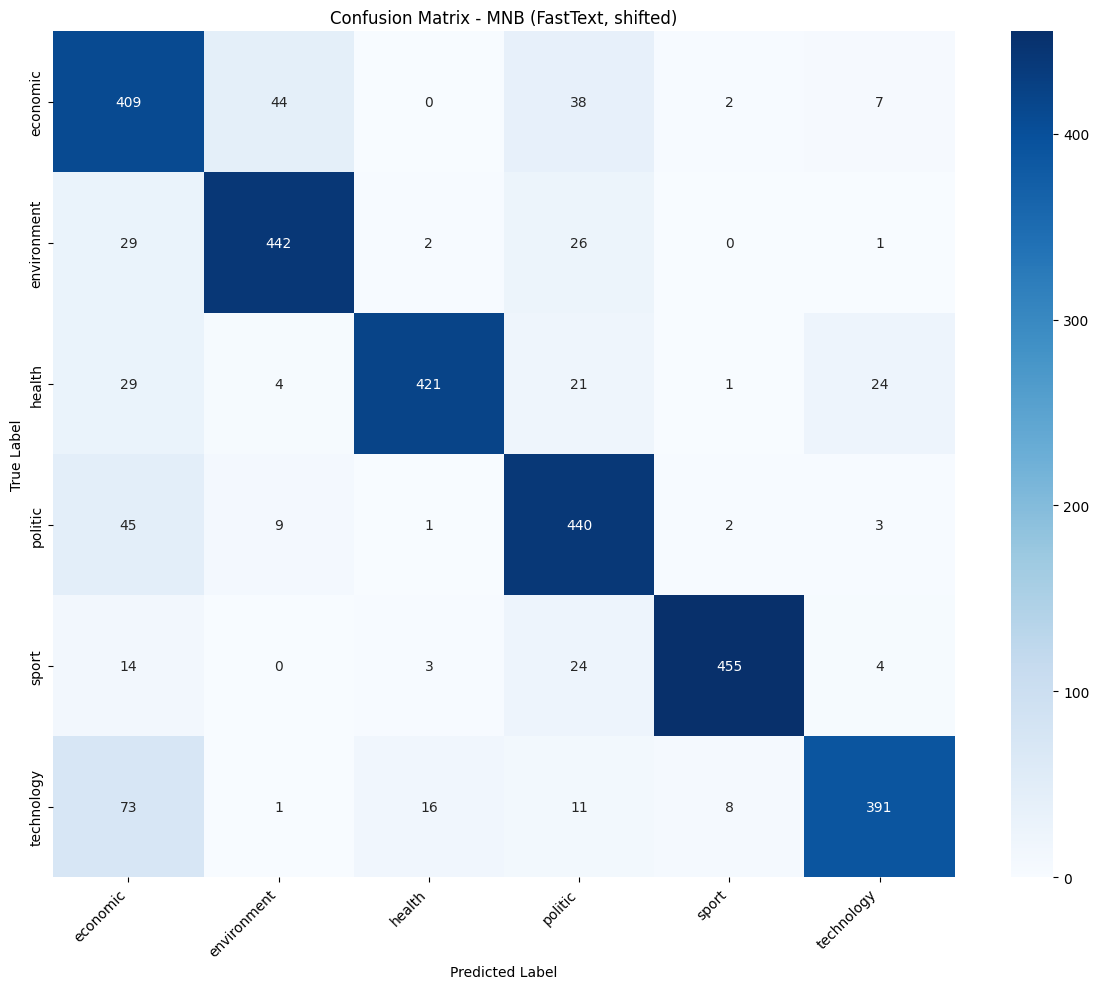


Classification Report:
              precision    recall  f1-score   support

    economic       0.68      0.82      0.74       500
 environment       0.88      0.88      0.88       500
      health       0.95      0.84      0.89       500
     politic       0.79      0.88      0.83       500
       sport       0.97      0.91      0.94       500
  technology       0.91      0.78      0.84       500

    accuracy                           0.85      3000
   macro avg       0.86      0.85      0.86      3000
weighted avg       0.86      0.85      0.86      3000


Generating ROC curves (one-vs-rest)...


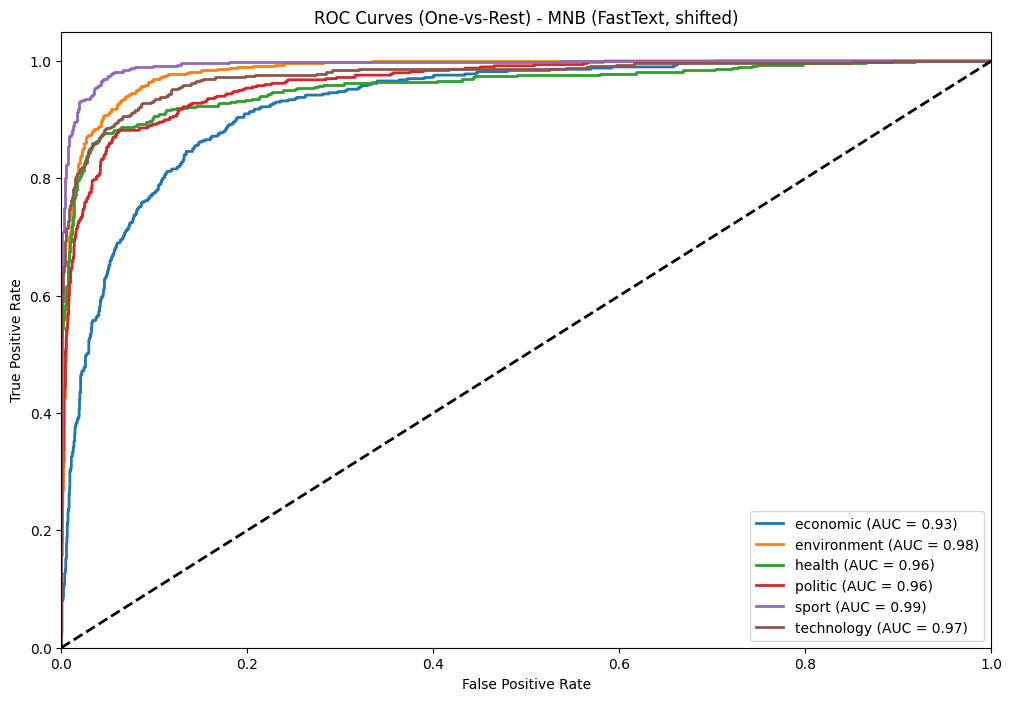


Model Comparison (FastText Features):
                model_name   cv_mean  accuracy  precision    recall        f1  \
0           SVM (FastText)  0.674417  0.678667   0.837546  0.678667  0.671535   
1  MNB (FastText, shifted)  0.849250  0.852667   0.864064  0.852667  0.855390   

   training_time  
0     533.240160  
1       0.153437  

Model Comparison (FastText Features):
                model_name   cv_mean  accuracy  precision    recall        f1  \
0           SVM (FastText)  0.674417  0.678667   0.837546  0.678667  0.671535   
1  MNB (FastText, shifted)  0.849250  0.852667   0.864064  0.852667  0.855390   

   training_time  
0     533.240160  
1       0.153437  


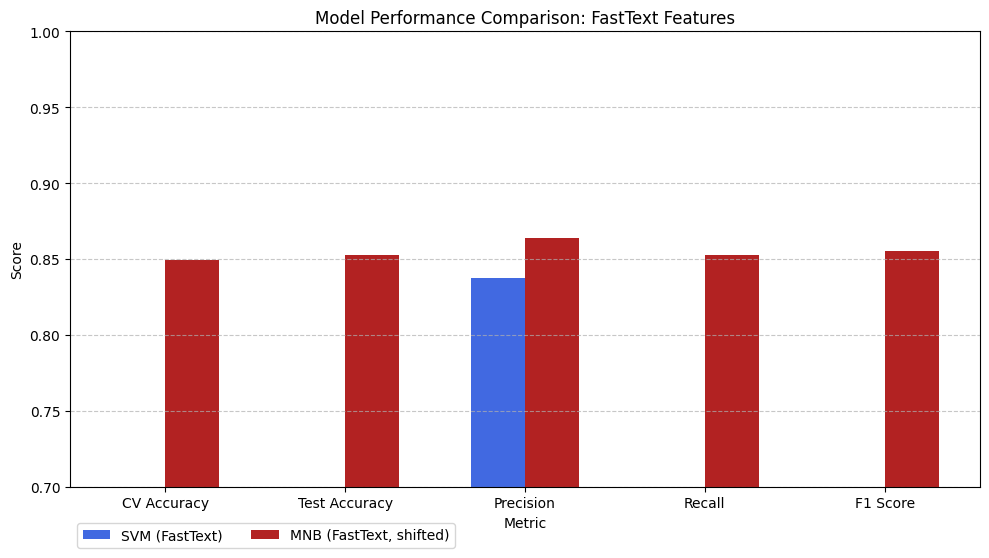


Best performing model overall: MNB (FastText, shifted) with accuracy: 0.8527
Best model and label encoder saved for production use

Error Analysis for Best Model

Error Analysis for MultinomialNB
Found 1481 misclassified instances out of 3000 test samples.

Categories with Highest Error Rates:
economic: 96.80% error rate (16/500 correctly classified)
technology: 91.80% error rate (41/500 correctly classified)
politic: 78.40% error rate (108/500 correctly classified)
sport: 15.00% error rate (425/500 correctly classified)
health: 14.00% error rate (430/500 correctly classified)
environment: 0.20% error rate (499/500 correctly classified)

Most Common Confusion Pairs (True -> Predicted):
economic -> environment: 480 instances
politic -> environment: 384 instances
technology -> environment: 358 instances
technology -> health: 88 instances
sport -> environment: 71 instances
health -> environment: 69 instances
technology -> sport: 10 instances
politic -> sport: 7 instances
technology -> ec

In [5]:
# --- FastText Feature Classification Pipeline ---

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import joblib
import warnings
warnings.filterwarnings('ignore')

# Define paths
FASTTEXT_DIR = '/Users/socheata/Documents/FYP-Khmer-Classification/FastText_Features'
MODELS_DIR = '/Users/socheata/Documents/FYP-Khmer-Classification/Models/fasttext_models'
os.makedirs(MODELS_DIR, exist_ok=True)

# Load FastText features and labels
print("Loading FastText features and labels...")
X = np.load(os.path.join(FASTTEXT_DIR, 'embeddings.npy'))           # shape: (n_samples, 300)
y = np.load(os.path.join(FASTTEXT_DIR, 'labels.npy'))               # shape: (n_samples,)
doc_ids = np.load(os.path.join(FASTTEXT_DIR, 'doc_ids.npy'))        # shape: (n_samples,)
label_encoder = joblib.load(os.path.join(FASTTEXT_DIR, 'label_encoder.pkl'))
# If y is already string labels, skip inverse_transform
if np.issubdtype(y.dtype, np.integer):
    labels_decoded = label_encoder.inverse_transform(y)
else:
    labels_decoded = y
print(f"Loaded {X.shape[0]} samples with {X.shape[1]}-dim FastText features.")

# Split the data
X_train, X_test, y_train, y_test, doc_ids_train, doc_ids_test = train_test_split(
    X, y, doc_ids, test_size=0.2, random_state=42, stratify=y
)
labels_train_decoded = y_train
labels_test_decoded = y_test
categories = list(label_encoder.classes_)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Categories: {categories}")

# Function to train and evaluate a model with cross-validation
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    print(f"\n{'='*50}")
    print(f"Training and evaluating {model_name}...")
    start_time = time.time()

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"CV accuracies: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    # Train on full training set
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    print(f"Training accuracy: {train_accuracy:.4f}")
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Save model
    joblib.dump(model, os.path.join(MODELS_DIR, f'{model_name.lower().replace(" ", "_")}.joblib'))
    print(f"{model_name} model saved")

    # Evaluate on test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_DIR, f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png'))
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=categories))

    # ROC curves (One-vs-Rest)
    try:
        print("\nGenerating ROC curves (one-vs-rest)...")
        lb = LabelBinarizer()
        lb.fit(y)
        y_test_bin = lb.transform(y_test)
        if hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            y_score = model.predict_proba(X_test)
        fpr, tpr, roc_auc = {}, {}, {}
        n_classes = len(categories)
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure(figsize=(12, 8))
        for i, category in enumerate(categories):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'{category} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves (One-vs-Rest) - {model_name}')
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(MODELS_DIR, f'{model_name.lower().replace(" ", "_")}_roc_curves.png'))
        plt.show()
    except Exception as e:
        print(f"Warning: Could not generate ROC curves. Error: {e}")

    return {
        'model_name': model_name,
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'training_time': training_time,
        'train_accuracy': train_accuracy
    }

print("\n" + "="*80)
print("Training models on FastText features")
print("="*80)

# Shift FastText embeddings to be non-negative for MNB (not recommended for production)
X_shift = X - X.min()  # Now all values >= 0

# Split the shifted data
X_train_shift, X_test_shift, _, _, _, _ = train_test_split(
    X_shift, y, doc_ids, test_size=0.2, random_state=42, stratify=y
)

# SVM (FastText, original)
svm_model = SVC(
    C=1,
    kernel='rbf',
    gamma=0.01,
    decision_function_shape='ovr',
    probability=True,
    random_state=42
)
svm_results = train_and_evaluate_model(
    "SVM (FastText)", svm_model, X_train, y_train, X_test, y_test
)

# MultinomialNB (FastText, shifted)
mnb_model = MultinomialNB()
mnb_results = train_and_evaluate_model(
    "MNB (FastText, shifted)", mnb_model, X_train_shift, y_train, X_test_shift, y_test
)

# Compare models
results = [svm_results, mnb_results]
model_comparison = pd.DataFrame(results)
print("\nModel Comparison (FastText Features):")
comparison_cols = ['model_name', 'cv_mean', 'accuracy', 'precision', 'recall', 'f1', 'training_time']
print(model_comparison[comparison_cols])


# Compare models
results = [svm_results, mnb_results]
model_comparison = pd.DataFrame(results)
print("\nModel Comparison (FastText Features):")
comparison_cols = ['model_name', 'cv_mean', 'accuracy', 'precision', 'recall', 'f1', 'training_time']
print(model_comparison[comparison_cols])

# Plot model comparison
metrics = ['cv_mean', 'accuracy', 'precision', 'recall', 'f1']
metric_labels = ['CV Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score']
model_names = [result['model_name'] for result in results]
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.3
colors = ['royalblue', 'firebrick']
for i, result in enumerate(results):
    values = [result[metric] for metric in metrics]
    plt.bar(x + (i-0.5)*width, values, width, label=result['model_name'], color=colors[i])
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Performance Comparison: FastText Features')
plt.xticks(x, metric_labels)
plt.legend(loc='lower left', bbox_to_anchor=(0, -0.15), ncol=2)
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(os.path.join(MODELS_DIR, 'fasttext_model_comparison.png'))
plt.show()

# Determine best overall model
all_accuracies = [svm_results['accuracy'], mnb_results['accuracy']]
best_model_idx = np.argmax(all_accuracies)
best_model_name = model_names[best_model_idx]
print(f"\nBest performing model overall: {best_model_name} with accuracy: {all_accuracies[best_model_idx]:.4f}")

# Save best model
best_model = svm_model if best_model_idx == 0 else mnb_model
joblib.dump(best_model, os.path.join(MODELS_DIR, 'best_model.joblib'))
joblib.dump(label_encoder, os.path.join(MODELS_DIR, 'best_label_encoder.joblib'))
print(f"Best model and label encoder saved for production use")

# Error analysis
def analyze_errors(model, X_test, y_test, categories, doc_ids_test, top_n=10):
    print(f"\n{'='*50}")
    print(f"Error Analysis for {model.__class__.__name__}")
    y_pred = model.predict(X_test)
    misclassified_indices = np.where(y_test != y_pred)[0]
    if len(misclassified_indices) == 0:
        print("No misclassified instances found.")
        return
    print(f"Found {len(misclassified_indices)} misclassified instances out of {len(y_test)} test samples.")
    errors_by_category = {}
    for idx in misclassified_indices:
        true_category = y_test[idx]      # <-- FIXED
        pred_category = y_pred[idx]      # <-- FIXED
        if true_category not in errors_by_category:
            errors_by_category[true_category] = []
        errors_by_category[true_category].append(pred_category)
    error_rates = {}
    for category in categories:
        category_count = sum(1 for y in y_test if y == category)
        if category_count == 0:
            continue
        misclassified_count = len(errors_by_category.get(category, []))
        error_rate = misclassified_count / category_count
        error_rates[category] = error_rate
    print("\nCategories with Highest Error Rates:")
    sorted_categories = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)
    for category, error_rate in sorted_categories[:top_n]:
        correct_count = sum(1 for y in y_test if y == category) - len(errors_by_category.get(category, []))
        total_count = sum(1 for y in y_test if y == category)
        print(f"{category}: {error_rate:.2%} error rate ({correct_count}/{total_count} correctly classified)")
    confusion_pairs = {}
    for true_category, errors in errors_by_category.items():
        for pred_category in errors:
            pair = (true_category, pred_category)
            confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1
    print("\nMost Common Confusion Pairs (True -> Predicted):")
    sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
    for (true_cat, pred_cat), count in sorted_pairs[:top_n]:
        print(f"{true_cat} -> {pred_cat}: {count} instances")

print("\n" + "="*80)
print("Error Analysis for Best Model")
print("="*80)
if best_model_idx == 0:
    analyze_errors(svm_model, X_test, y_test, categories, doc_ids_test)
else:
    analyze_errors(mnb_model, X_test, y_test, categories, doc_ids_test)

print("\n" + "="*80)
print("Training and Evaluation Complete!")
print("="*80)
print(f"All models and label encoder saved in: {MODELS_DIR}")
print(f"Best model: {best_model_name}")
print("\nUse the following code to load and use the best model for prediction:")
print("```python")
print("import joblib")
print("# Load best model and label encoder")
print("model = joblib.load('path/to/best_model.joblib')")
print("label_encoder = joblib.load('path/to/best_label_encoder.joblib')")
print("# For prediction:")
print("X_new = ... # shape (n_samples, 300) FastText embedding(s)")
print("y_pred = model.predict(X_new)")
print("labels = label_encoder.inverse_transform(y_pred)")
print("```")